## Analyzed Phillips 2 layer simulations 


In [1]:
import xarray as xr
import xrft
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%reload_ext autoreload
%autoreload 2
    
from sim_analysis_modules import create_leaf, analyze_sims

In [3]:
scales = ['04','10','20','30','40','80']
scales_array = np.array(scales, dtype=float)
scales_array

array([ 4., 10., 20., 30., 40., 80.])

In [4]:
ds_no_param_dic = {}


for L in scales:
    if L == '04':
        create_leaf(ds_no_param_dic, ['04'],analyze_sims('/scratch/db194/mom6/tests_Phillips_2layer/generate_training_data/Phillips_2layer_4km_10day/'))
    else: 
        create_leaf(ds_no_param_dic, [L],analyze_sims('/scratch/db194/mom6/tests_Phillips_2layer/Phillips_2layer_'+L+'km/'))

ERROR 1: PROJ: proj_create_from_database: Open of /ext3/miniforge/share/proj failed


### Overturning

Text(0.5, 0, 'y [km]')

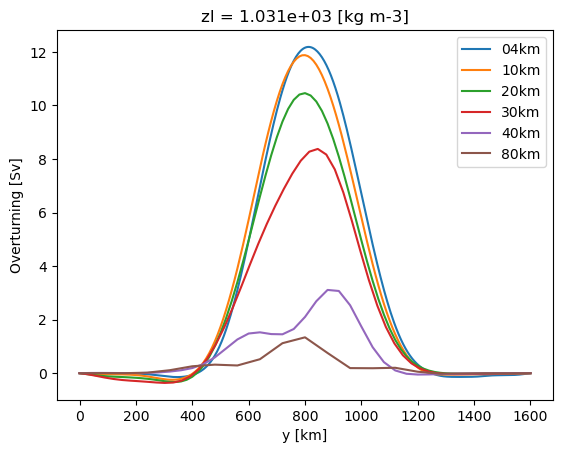

In [83]:
OT_max = np.zeros_like(scales_array)

for i, L in enumerate(scales): 
    ds = ds_no_param_dic[L] 

    OT = ds.Vbar_resolved.sel(Time=slice(360, None)).mean('Time')
    OT_max[i] = OT.max().values
    OT.plot(label=L+'km')

plt.legend()
plt.ylabel('Overturning [Sv]')
plt.xlabel('y [km]')

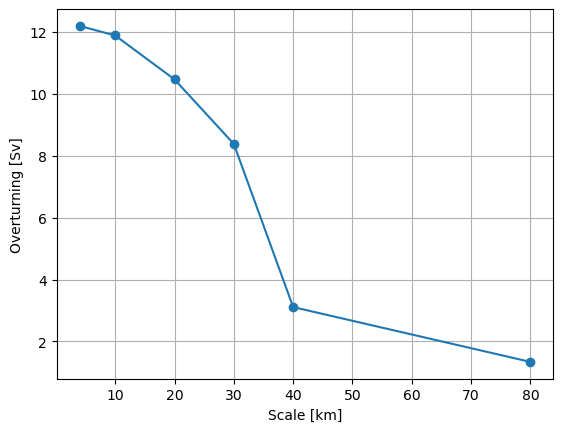

In [84]:
plt.plot(scales_array, OT_max, marker='o')
plt.xlabel('Scale [km]')
plt.ylabel('Overturning [Sv]')
plt.grid()

## Mean state

In [85]:
common_y = np.linspace(100, 1500, 101) 
hmean_HR = ds_no_param_dic['04'].prog.e.isel(zi=1).mean('xh').sel(Time=slice(360, None)).mean('Time')
hmean_HR_int = hmean_HR.interp(yh=common_y)

Text(0.5, 0, 'y [km]')

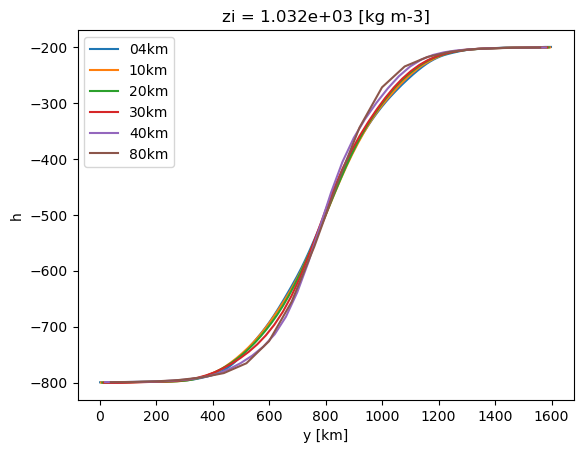

In [86]:
hmean_err = np.zeros_like(scales_array)

for i, L in enumerate(scales): 
    ds = ds_no_param_dic[L] 

    hmean = ds.prog.e.isel(zi=1).mean('xh').sel(Time=slice(360, None)).mean('Time')
    hmean_int = hmean.interp(yh=common_y)
    hmean_err[i] = (((hmean_int - hmean_HR_int)**2).mean('yh'))**0.5
    hmean.plot(label=L+'km')

plt.legend()
plt.ylabel('h')
plt.xlabel('y [km]')

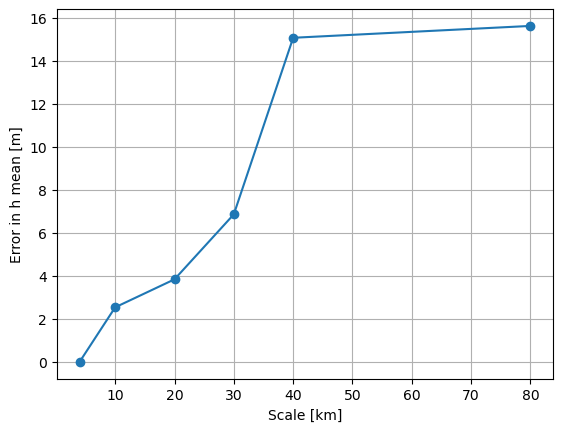

In [87]:
plt.plot(scales_array, hmean_err, marker='o')
plt.xlabel('Scale [km]')
plt.ylabel('Error in h mean [m]')
plt.grid()

## KE and PE

In [98]:
from xgcm import Grid

def KE_HR(ds):
    xgrid = Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
                             'Y': {'center': 'yh', 'outer': 'yq'},
                             'Z': {'center': 'zl', 'outer': 'zi'} },
                 periodic=['X'])
    
    Umean = ds.u.mean(['Time','xq'])
    Vmean = ds.v.mean(['Time','xh'])
    
    Up = ds.u - Umean
    Vp = ds.v - Vmean
    
    MKE = 0.5*( Umean**2 + xgrid.interp(Vmean,'Y', boundary='extend')**2)
    EKE = 0.5*( xgrid.interp(Up, 'X')**2 + xgrid.interp(Vp,'Y', boundary='extend')**2).mean(['Time','xh'])

    return MKE.mean(['yh','zl']).values, EKE.mean(['yh','zl']).values

def PE_HR(ds): 

    gr = np.zeros(3)
    gr[0] = 9.81
    gr[1] = gr[0] * (ds.zl[1] - ds.zl[0])/ds.zl[0]
    gr[2] = 0.

    ds['gr'] = xr.DataArray(gr, dims={'zi'})

    eGlobMean = ds.e.mean(['Time','xh','yh'])
    eMean = ds.e.mean(['Time','xh']) - eGlobMean

    PE = (0.5* ds.gr * (ds.e - eGlobMean)**2).sum('zi').mean(['Time','xh','yh'])
    MPE = (0.5* ds.gr * eMean**2).sum('zi').mean(['yh'])
    EPE = PE - MPE

    return MPE, EPE

In [100]:
ds_no_param_dic

{'04': Data for sim at: /scratch/db194/mom6/tests_Phillips_2layer/generate_training_data/Phillips_2layer_4km_10day/,
 '10': Data for sim at: /scratch/db194/mom6/tests_Phillips_2layer/Phillips_2layer_10km/,
 '20': Data for sim at: /scratch/db194/mom6/tests_Phillips_2layer/Phillips_2layer_20km/,
 '30': Data for sim at: /scratch/db194/mom6/tests_Phillips_2layer/Phillips_2layer_30km/,
 '40': Data for sim at: /scratch/db194/mom6/tests_Phillips_2layer/Phillips_2layer_40km/,
 '80': Data for sim at: /scratch/db194/mom6/tests_Phillips_2layer/Phillips_2layer_80km/}

In [102]:
MKE = np.zeros_like(scales_array)
EKE = np.zeros_like(scales_array)

MPE = np.zeros_like(scales_array)
EPE = np.zeros_like(scales_array)

for i, L in enumerate(scales): 
    print(L)
    ds = ds_no_param_dic[L].prog

    
    MKE[i], EKE[i] = KE_HR(ds.sel(Time=slice(360, None)))
    
    MPE[i], EPE[i] = PE_HR(ds.sel(Time=slice(360, None)))

04
10
20
30
40
80


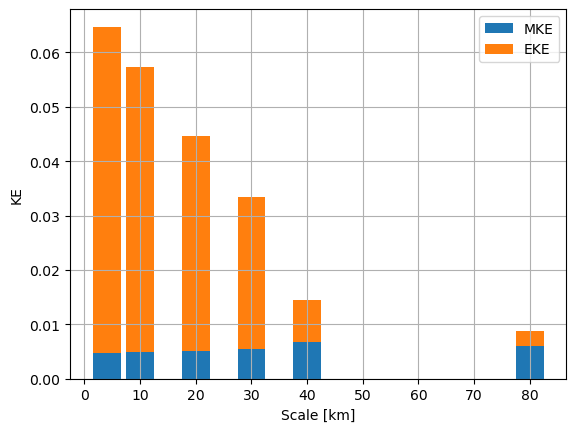

In [97]:
KE = {"MKE":MKE, 
      "EKE":EKE }

width=5
fig, ax = plt.subplots()
bottom = np.zeros(len(scales_array))

for boolean, weight_count in KE.items():
    p = ax.bar(scales_array, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_xlabel('Scale [km]')
ax.set_ylabel('KE')
ax.legend(loc='best')
plt.grid()

(500.0, 700.0)

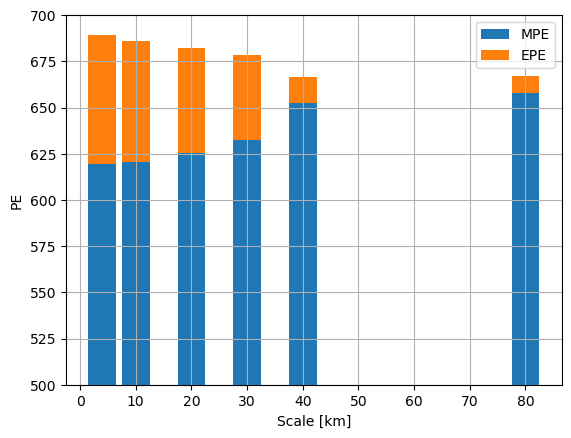

In [105]:
PE = {"MPE":MPE, 
      "EPE":EPE }

width=5
fig, ax = plt.subplots()
bottom = np.zeros(len(scales_array))

for boolean, weight_count in PE.items():
    p = ax.bar(scales_array, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_xlabel('Scale [km]')
ax.set_ylabel('PE')
ax.legend(loc='best')
plt.grid()
plt.ylim(500, 700)